In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [2]:
params = {'legend.fontsize': 14,
          'figure.figsize': (12, 8),
          'axes.labelsize': 14,
          'axes.titlesize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14}
plt.rcParams.update(params)

# WASP 4b Expolanet Data Analysis

Original publication: `WASP-4b Arrived Early for the TESS Mission` https://arxiv.org/abs/1903.02573

In [3]:
t, f = np.load('WASP_4b.npy')
t -= np.min(t)

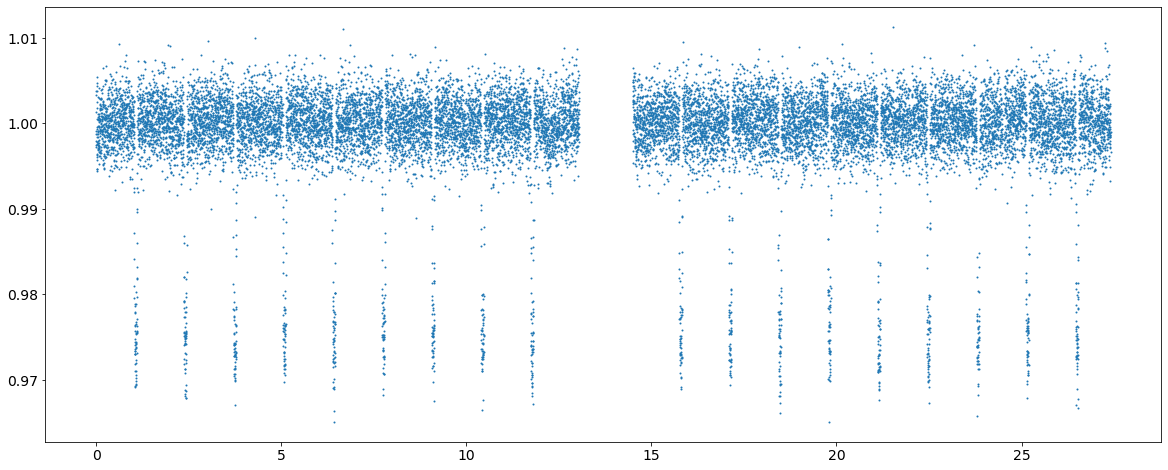

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))
plt.plot(t, f, '.', ms=2)

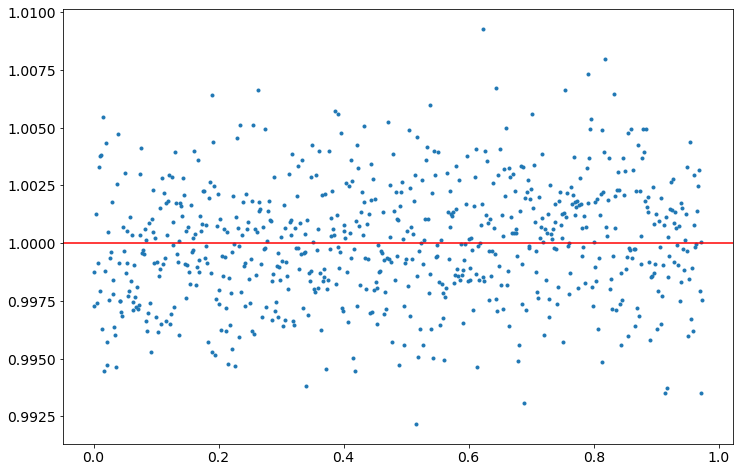

In [5]:
idx = slice(None, 700)
plt.plot(t[idx], f[idx], '.')
plt.axhline(1, c='r')

In [7]:
f_var = np.mean((f[idx] - 1)**2)
f_error = np.sqrt(f_var)

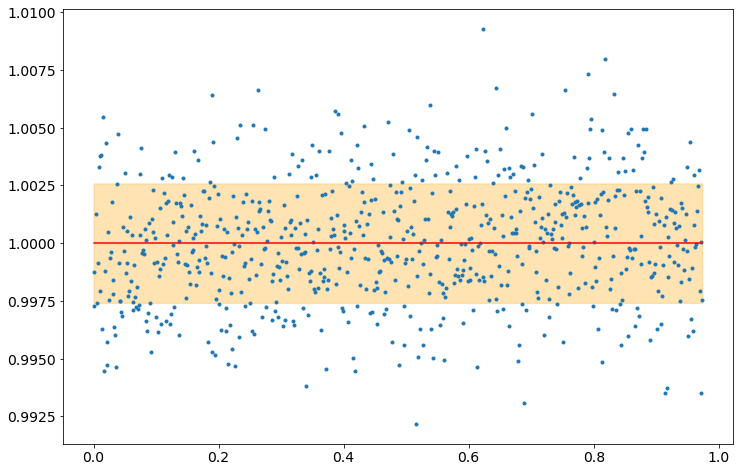

In [135]:
idx = slice(None, 700)
plt.plot(t[idx], f[idx], '.')
plt.plot(t[idx], np.ones_like(f[idx]), c='r')
plt.gca().fill_between(t[idx], 1-f_error, 1+f_error, color='orange', alpha=0.3)

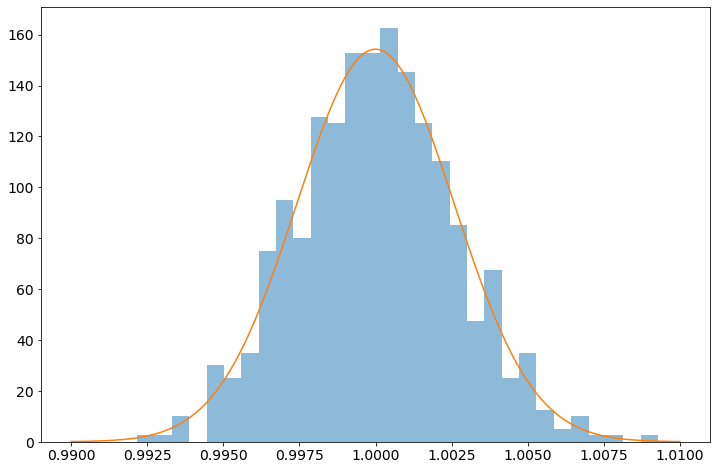

In [9]:
plt.hist(f[idx], bins=30, density=True, alpha=0.5)
l = np.linspace(0.99, 1.01, 1000)
plt.plot(l, stats.norm(1, f_error).pdf(l))

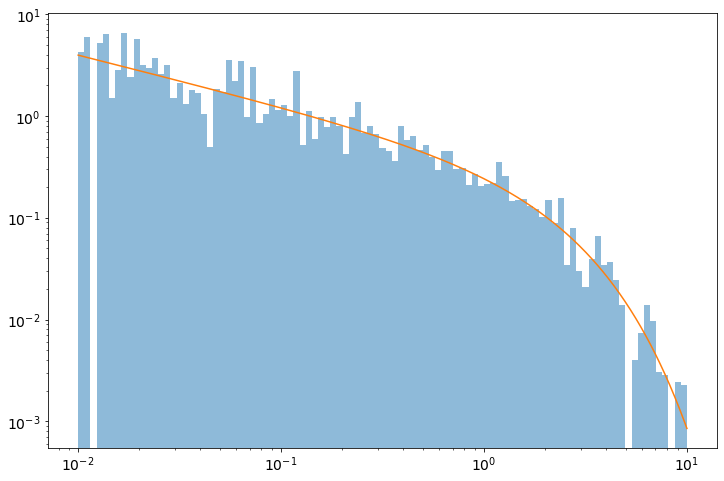

In [10]:
plt.hist(((f[idx] - 1)/f_error)**2, bins=np.logspace(-2,1,100), density=True, alpha=0.5);
l = np.logspace(-2, 1, 1000)
plt.plot(l, stats.chi2(1).pdf(l))
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

In [141]:
# Goodness of fit?
stats.chi2(df=len(f[idx])).sf(np.sum(((f[idx] - 1)/f_error)**2))

0.49289176727180817

In [11]:
def model_box(params, t):
    period, phase, length, radius = params
    dt = t - phase*period
    dt = dt % period
    expected = np.ones_like(t)
    mask = dt < length * period
    expected[mask] = 1 - radius**2
    return expected

In [12]:
idx = slice(0, 2000)

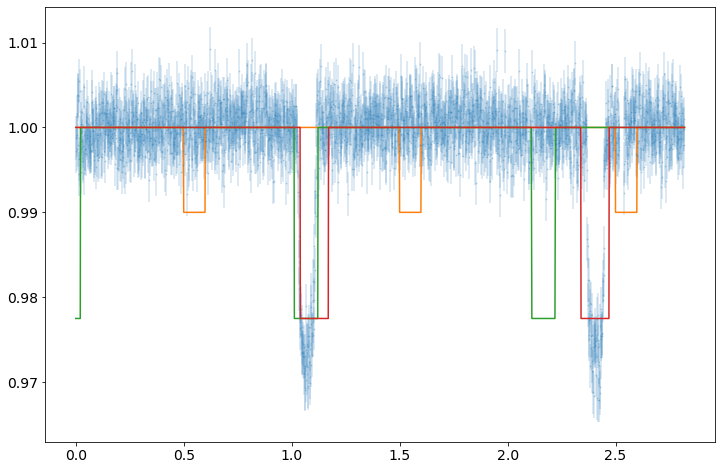

In [15]:
plt.errorbar(t[idx],f[idx], yerr=np.sqrt(f_var), fmt='o', ms=1, alpha=0.2)

p_guess = [1., 0.5, 0.1, 0.1]
plt.plot(t[idx], model_box(p_guess, t[idx]))

p_guess = [1.1, 0.92, 0.1, 0.15]
plt.plot(t[idx], model_box(p_guess, t[idx]))

p_guess = [1.3, 0.8, 0.1, 0.15]
plt.plot(t[idx], model_box(p_guess, t[idx]))

In [16]:
def nllh_box(params, t, f):
    expected = model_box(params, t)
    return -np.sum(stats.norm.logpdf(f, loc=expected, scale=f_error))

In [17]:
nllh_box(p_guess, t, f)

17469.40053946138

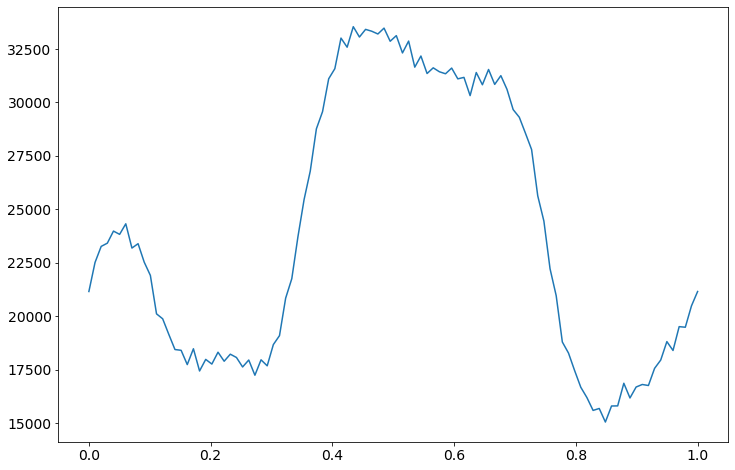

In [18]:
phases = np.linspace(0,1,100)
llhs = []
p = np.copy(p_guess)
for phase in phases:
    p[1] = phase
    llhs.append(nllh_box(p, t, f))

plt.plot(phases, llhs)

In [19]:
from scipy import optimize

In [20]:
# period, phase, duty cycle, radius
bounds_box = [[0.1,10], [0,1], [0.01, 0.5], [0.01, 0.5]]

In [21]:
mle_box = optimize.minimize(nllh_box, x0=p_guess , bounds=bounds_box, args=(t,f), method='Nelder-Mead')

In [30]:
mle_box

 final_simplex: (array([[1.33821329, 0.77201648, 0.05526367, 0.1566592 ],
       [1.33821487, 0.77200669, 0.05526188, 0.15665561],
       [1.33821505, 0.7720051 , 0.05526126, 0.15665966],
       [1.33821516, 0.77200735, 0.05525984, 0.15665432],
       [1.33821493, 0.77200567, 0.05526282, 0.15666077]]), array([-81251.74805288, -81251.74805101, -81251.74804018, -81251.74800658,
       -81251.74799738]))
           fun: -81251.7480528803
       message: 'Optimization terminated successfully.'
          nfev: 107
           nit: 49
        status: 0
       success: True
             x: array([1.33821329, 0.77201648, 0.05526367, 0.1566592 ])

In [29]:
mle_box = optimize.minimize(nllh_box, x0=mle_box.x , bounds=bounds_box, args=(t,f), method='Nelder-Mead')

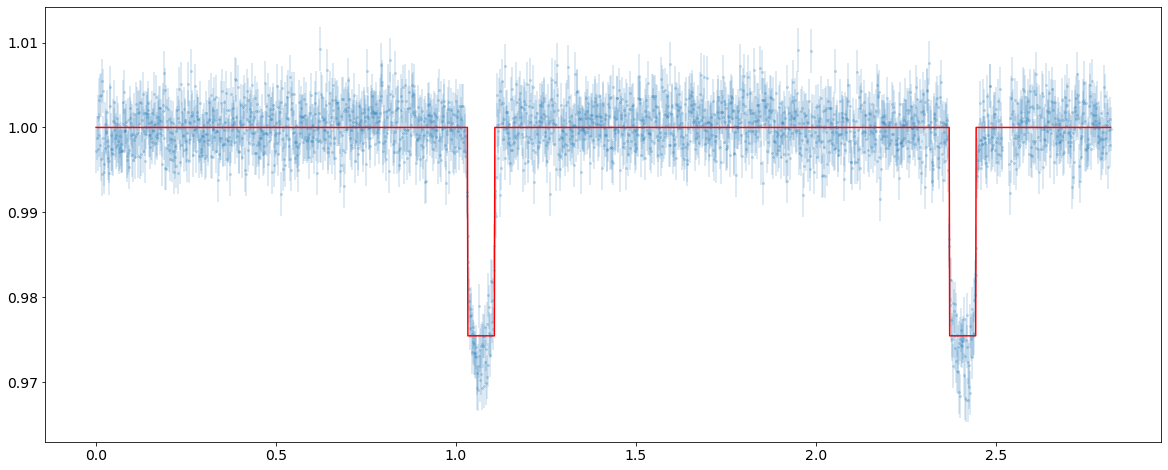

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))

idx = slice(0, 2000)
plt.errorbar(t[idx],f[idx], yerr=np.sqrt(f_var), fmt='o', ms=2, alpha=0.2)
plt.plot(t[idx], model_box(mle_box.x, t[idx]), c='r')

In [33]:
mle_box.x

array([1.33821329, 0.77201648, 0.05526367, 0.1566592 ])

# Paper:
* period =  1.338231466
* r/R = 0.15201

# CLs

In [35]:
radii = np.linspace(mle_box.x[3]-0.001, mle_box.x[3]+0.001, 1000)
llhs = []

p = np.copy(mle_box.x)

for r in radii:
    p[3] = r
    llhs.append(nllh_box(p, t, f))
    
llhs = np.array(llhs)

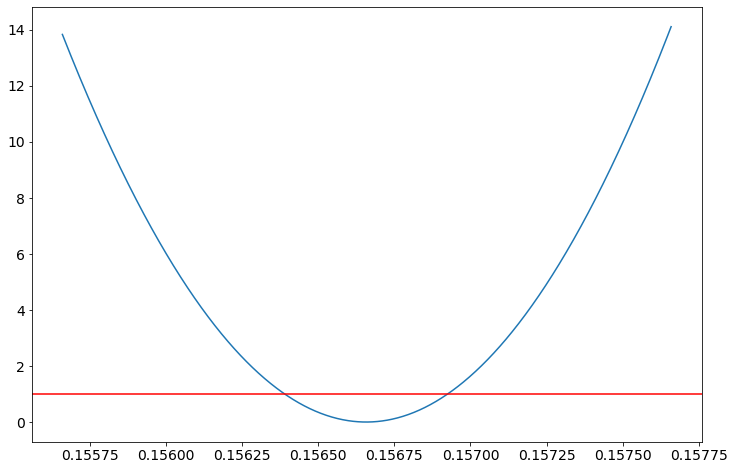

In [37]:
plt.plot(radii, 2*(llhs - mle_box.fun))
plt.axhline(1, c='r')

In [38]:
interval = radii[np.argwhere(2*(llhs-mle_box.fun) < 1)]

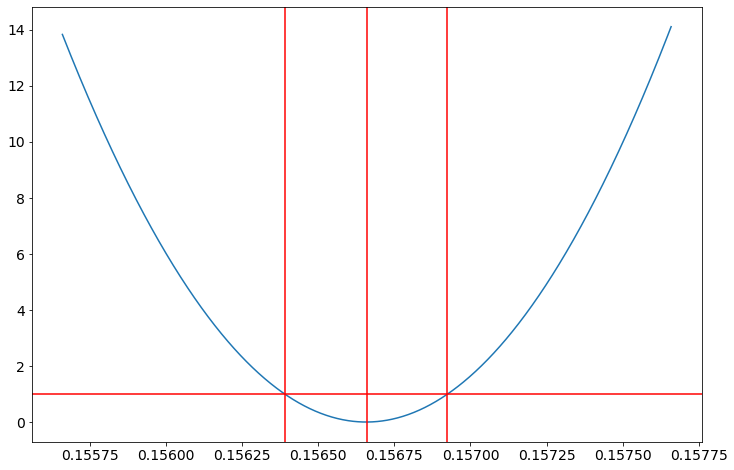

In [40]:
plt.plot(radii, 2*(llhs-np.min(llhs)))
plt.axhline(1, c='r')
plt.axvline(np.min(interval), c='r')
plt.axvline(np.max(interval), c='r')
plt.axvline(mle_box.x[3], c='r')

In [41]:
print('r/R = %.4f +%.5f -%.5f (68%% C.L.)'%(mle_box.x[3], mle_box.x[3] - np.min(interval), np.max(interval) - mle_box.x[3]))

r/R = 0.1567 +0.00027 -0.00027 (68% C.L.)


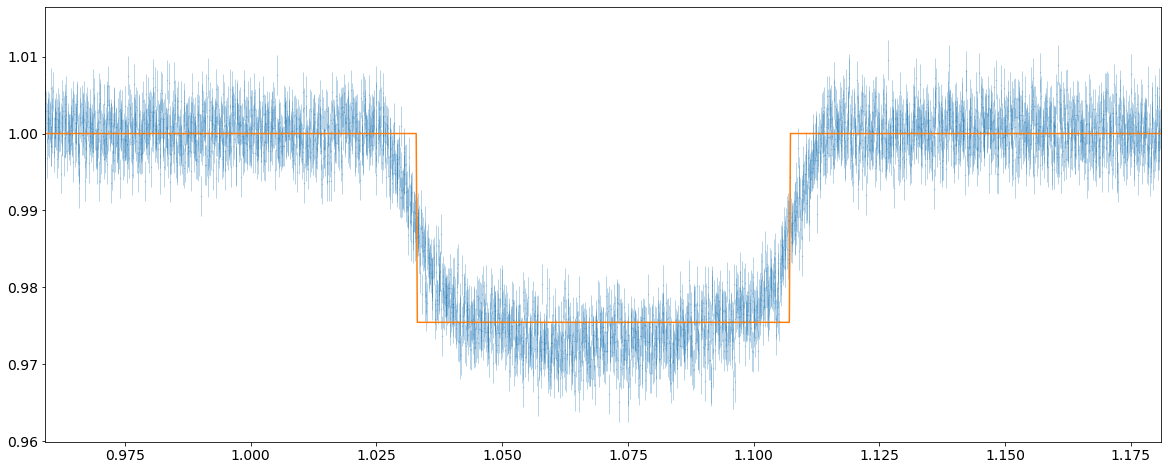

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))

dt = t - np.min(t)
dt = dt % mle_box.x[0]
plt.errorbar(dt, f, yerr=f_error, fmt='.', lw=1, ms=1, alpha=0.3)

window = (mle_box.x[1]*mle_box.x[0] - mle_box.x[2]*mle_box.x[0], mle_box.x[1]*mle_box.x[0] + 2 * mle_box.x[2]*mle_box.x[0])
ax.set_xlim(*window)

ts = np.linspace(*window,1000)

ax.plot(ts, model_box(mle_box.x, ts))

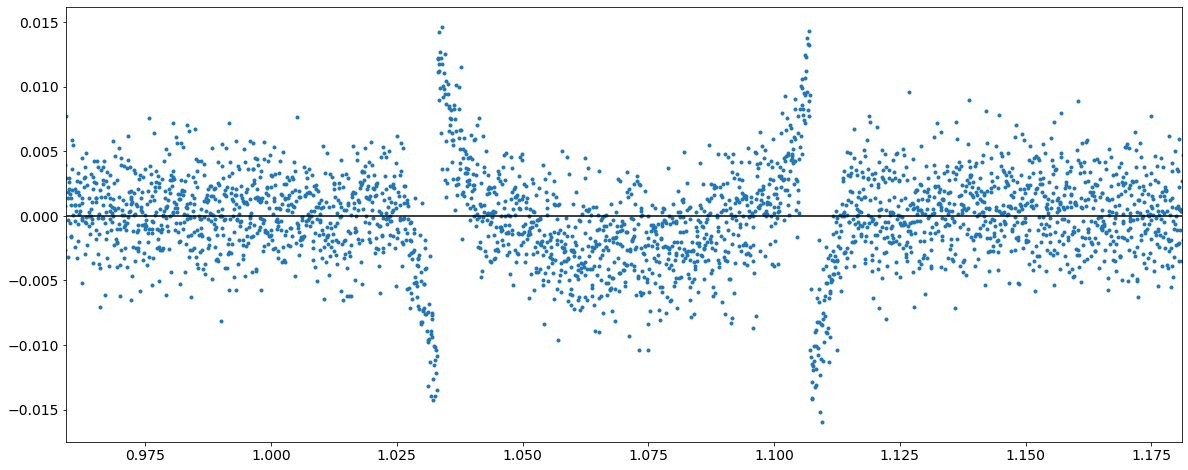

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))
plt.plot(dt, f - model_box(mle_box.x, t), '.')
ax.set_xlim(*window)
ax.axhline(0, c='k')

## Goodness-of-fit

In [44]:
chi2 = np.sum((f - model_box(mle_box.x, t))**2/f_var)

In [49]:
# p-value
stats.chi2(df=len(t)).sf(chi2)

2.067542830516045e-76

# Better Model

In [51]:
# http://hpparvi.github.io/PyTransit/

from pytransit import QuadraticModel
tm = QuadraticModel()

def model_transit(p, t):
    period, phase, a, radius, i = p
    phase *= period
    tm.set_data(t)
    return tm.evaluate(k=radius, ldc=[0.382, 0.21], t0=phase, p=period, a=a, i=i)

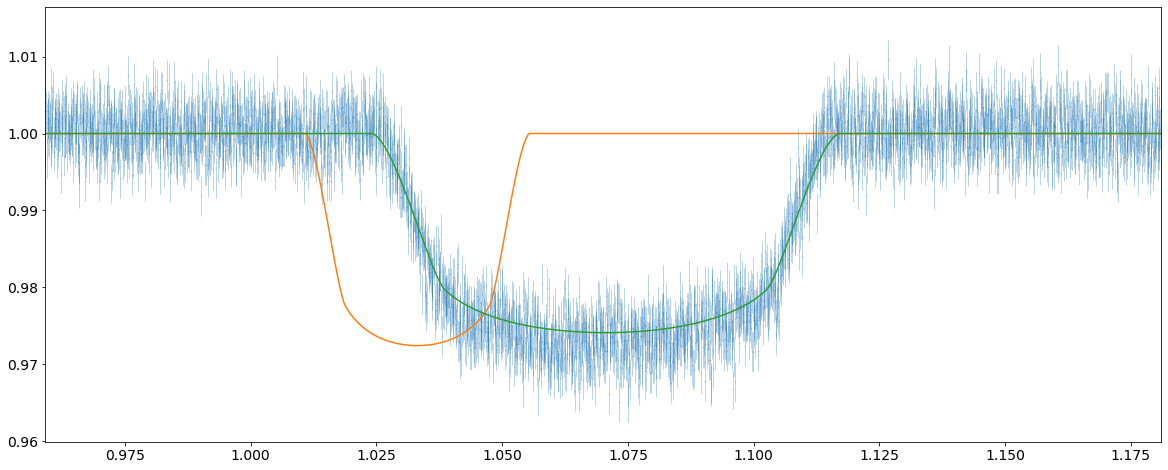

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))

dt = t % mle_box.x[0]
plt.errorbar(dt, f, yerr=f_error, fmt='.', lw=1, ms=1, alpha=0.3)

ax.set_xlim(*window)

ts = np.linspace(*window, 1000)

p_guess = [mle_box.x[0], mle_box.x[1], 10, mle_box.x[3], 0.5*np.pi + 0.05]

ax.plot(ts, model_transit(p_guess, ts))

p_guess = [mle_box.x[0], 0.8, 5, 0.15, 0.5*np.pi+0.08]

ax.plot(ts, model_transit(p_guess, ts))

In [53]:
def nllh_transit(p, t, f):
    expected = model_transit(p, t)
    return -np.sum(stats.norm.logpdf(f, loc=expected, scale=f_error))

In [54]:
bounds_transit = [[0.1,10], [0,1], [1,50], [0.01,0.5], [0.5*np.pi, 0.5*np.pi + 0.1]]

In [55]:
mle_transit = optimize.minimize(nllh_transit, x0=p_guess , bounds=bounds_transit, args=(t,f), method='Nelder-Mead')

In [71]:
mle_transit = optimize.minimize(nllh_transit, x0=mle_transit.x , bounds=bounds_transit, args=(t,f), method='Nelder-Mead')

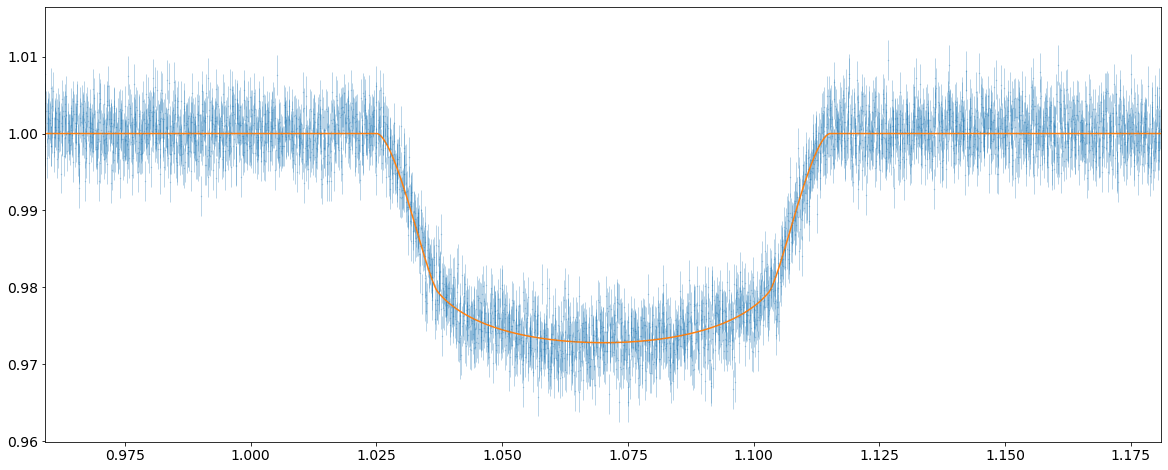

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))
plt.errorbar(dt, f, yerr=f_error, fmt='.', lw=1, ms=1, alpha=0.3)
ax.set_xlim(*window)
ax.plot(ts, model_transit(mle_transit.x, ts))

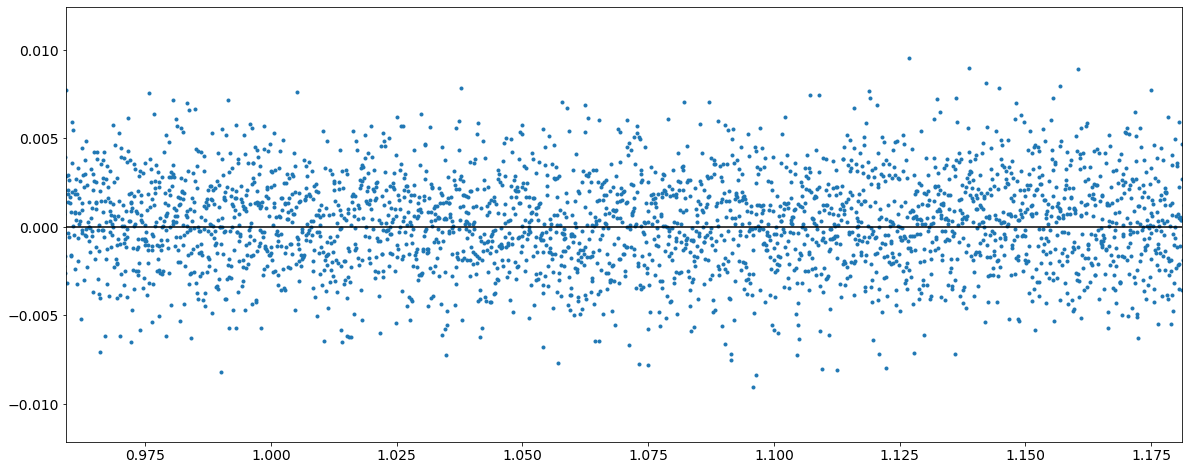

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))
plt.plot(dt, f - model_transit(mle_transit.x, t), '.')
ax.set_xlim(*window)
ax.axhline(0, c='k')

In [123]:
expected = model_transit(mle_transit.x, t)
chi2 = np.sum((f - expected)**2/f_var)
# p-value
stats.chi2(df=len(t)).sf(chi2)

3.19164349213098e-08

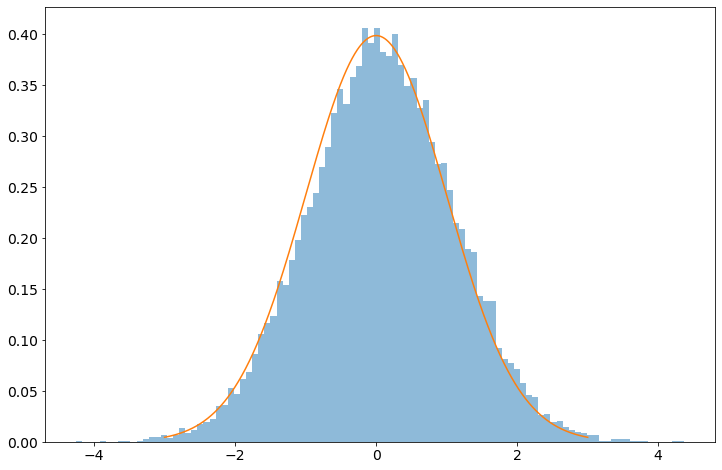

In [124]:
plt.hist((f - expected)/f_error, bins=100, density=True, alpha=0.5);
l = np.linspace(-3, 3, 1000)
plt.plot(l, stats.norm().pdf(l))

#plt.gca().set_yscale('log')

In [125]:
mask = (dt > window[0]) & (dt < window[1])

In [126]:
chi2 = np.sum((f[mask] - expected[mask])**2/f_var)
# p-value
stats.chi2(df=np.sum(mask)).sf(chi2)

1.6717671884480275e-05

# Profile LLH

In [79]:
bounds_transit = np.stack([mle_transit.x, mle_transit.x]).T
bounds_transit[:,0] *= 0.9
bounds_transit[:,1] *= 1.1

In [80]:
radii = np.linspace(mle_transit.x[3]-0.001, mle_transit.x[3]+0.001, 30)

llhs = []
llhs_no_profile = []

for r in radii:    
    fun = lambda x : nllh_transit([x[0], x[1], x[2], r, x[3]], t, f)
    x0 = mle_transit.x[[0,1,2,4]]
    b = bounds_transit[[0,1,2,4]]
    res = optimize.minimize(fun, x0=x0 , bounds=b, method='Nelder-Mead')
    llhs.append(res.fun)
    
    p = np.copy(mle_transit.x)
    p[3] = r
    llhs_no_profile.append(nllh_transit(p, t, f))
    
llhs = np.array(llhs)
llhs_no_profile = np.array(llhs_no_profile)

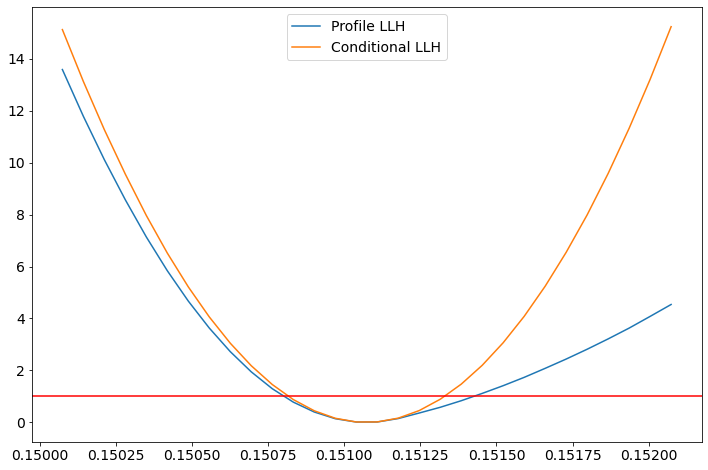

In [81]:
plt.plot(radii, 2*(llhs - mle_transit.fun), label="Profile LLH")
plt.plot(radii, 2*(llhs_no_profile - mle_transit.fun), label="Conditional LLH")
plt.legend()
plt.axhline(1, c='r')

In [82]:
interval = radii[np.argwhere(2*(llhs-mle_transit.fun) < 1)]

In [83]:
print('r/R = %.4f +%.5f -%.5f (68%% C.L.)'%(mle_transit.x[3], np.max(interval) - mle_transit.x[3],  mle_transit.x[3] - np.min(interval)))

r/R = 0.1511 +0.00031 -0.00024 (68% C.L.)


# Hypothesis Testing

In [84]:
def model_transit_noldc(p, t):
    period, phase, a, radius, i = p
    phase *= period
    tm.set_data(t)
    return tm.evaluate(k=radius, ldc=[0.,0.], t0=phase, p=period, a=a, i=np.pi/2)

In [85]:
def nllh_transit_noldc(p, t, f):
    expected = model_transit_noldc(p, t)
    return -np.sum(stats.norm.logpdf(f, loc=expected, scale=f_error))

In [86]:
bounds_transit_noldc = [[0.1,10], [0,1], [1,50], [0.01,0.5], [0.5*np.pi, 0.5*np.pi + 0.1]]
mle_transit_noldc = optimize.minimize(nllh_transit_noldc, x0=p_guess , bounds=bounds_transit_noldc, args=(t,f), method='Nelder-Mead')

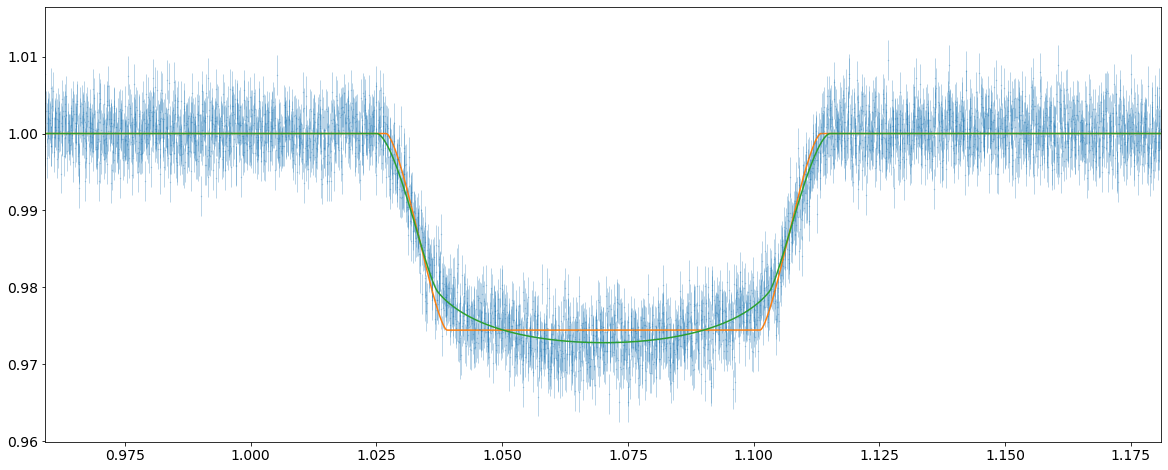

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))
plt.errorbar(dt, f, yerr=f_error, fmt='.', lw=1, ms=1, alpha=0.3)
ax.set_xlim(*window)
ax.plot(ts, model_transit_noldc(mle_transit_noldc.x, ts))
ax.plot(ts, model_transit(mle_transit.x, ts))

In [88]:
bounds_transit_noldc = np.stack([mle_transit_noldc.x, mle_transit_noldc.x]).T
bounds_transit_noldc[:,0] *= 0.9
bounds_transit_noldc[:,1] *= 1.1

In [89]:
def noldc_MC(p, t):
    expected = model_transit_noldc(p, t)
    return stats.norm.rvs(loc=expected, scale=f_error)

def ldc_MC(p, t):
    expected = model_transit(p, t)
    return stats.norm.rvs(loc=expected, scale=f_error)

In [90]:
from tqdm import tqdm

In [91]:
h0 = []
h1 = []

for i in tqdm(range(100)):
    f_test = noldc_MC(mle_transit_noldc.x, t)
    mle1 = optimize.minimize(nllh_transit_noldc, x0=mle_transit_noldc.x , bounds=bounds_transit_noldc, args=(t,f_test), method='Nelder-Mead')
    mle2 = optimize.minimize(nllh_transit, x0=mle_transit.x , bounds=bounds_transit, args=(t,f_test), method='Nelder-Mead')
    h0.append(mle1.fun - mle2.fun)

    f_test = ldc_MC(mle_transit.x, t)
    mle1 = optimize.minimize(nllh_transit_noldc, x0=mle_transit_noldc.x , bounds=bounds_transit_noldc, args=(t,f_test), method='Nelder-Mead')
    mle2 = optimize.minimize(nllh_transit, x0=mle_transit.x , bounds=bounds_transit, args=(t,f_test), method='Nelder-Mead')
    h1.append(mle1.fun - mle2.fun)

100%|██████████| 100/100 [00:42<00:00,  2.33it/s]


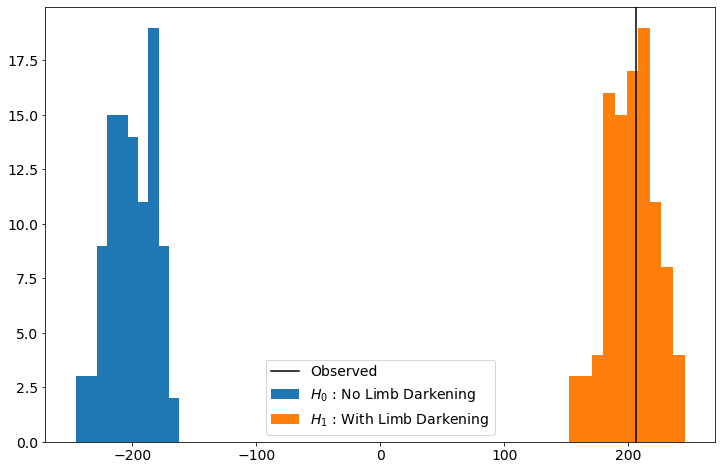

In [92]:
plt.hist(h0, label=r'$H_0$ : No Limb Darkening')
plt.hist(h1, label=r'$H_1$ : With Limb Darkening')
plt.axvline(mle_transit_noldc.fun - mle_transit.fun, c='k', label='Observed')

plt.legend()

# Bayesian

In [93]:
import ultranest

In [94]:
param_names = ['period', 'phase', 'a', 'r', 'i']

In [95]:
def likelihood(params):
    return -nllh_transit(params, t, f)

In [96]:
def prior_transform(cube):
    params = cube * (bounds_transit[:,1] - bounds_transit[:,0]) + bounds_transit[:,0]
    return params

In [97]:
sampler = ultranest.ReactiveNestedSampler(param_names, likelihood, prior_transform)

In [98]:
%%time
result = sampler.run()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=8e+04  2606.63 [82606.3846..82606.3848]*| it/evals=11920/163859 eff=7.2923% N=400 
[ultranest] Likelihood function evaluations: 163890
[ultranest]   logZ = 8.258e+04 +- 0.1959
[ultranest] Effective samples strategy satisfied (ESS = 2274.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.20, need <0.5)
[ultranest]   logZ error budget: single: 0.24 bs:0.20 tail:0.01 total:0.20 required:<0.50
[ultranest] done iterating.
CPU times: user 2min 8s, sys: 1.45 s, total: 2min 10s
Wall time: 2min 7s


In [99]:
result

{'niter': 12326,
 'logz': 82581.25081063606,
 'logzerr': 0.3089620903829087,
 'logz_bs': 82581.18093751928,
 'logz_single': 82581.25081063606,
 'logzerr_tail': 0.009947652870323509,
 'logzerr_bs': 0.3088019065617118,
 'ess': 2274.632869082776,
 'H': 23.05488357465947,
 'Herr': 0.18687815113732456,
 'posterior': {'mean': [1.3382333502625934,
   0.7996557421864959,
   5.464771170954621,
   0.1512426795518794,
   1.570335997203538],
  'stdev': [1.2761826309920243e-05,
   0.00011424218349344599,
   0.034277311285502716,
   0.0003468020047335242,
   0.018937867101344746],
  'median': [1.338233081587496,
   0.7996544507908714,
   5.473367248424277,
   0.15121321908020413,
   1.5707009987144476],
  'errlo': [1.3382211982771783,
   0.7995432116319884,
   5.4359112305430175,
   0.15091110387233655,
   1.5502106772568032],
  'errup': [1.3382462461761733,
   0.7997674484724395,
   5.493553967463938,
   0.15156881615754136,
   1.590751311755916],
  'information_gain_bits': [4.14647919764959,
   4.

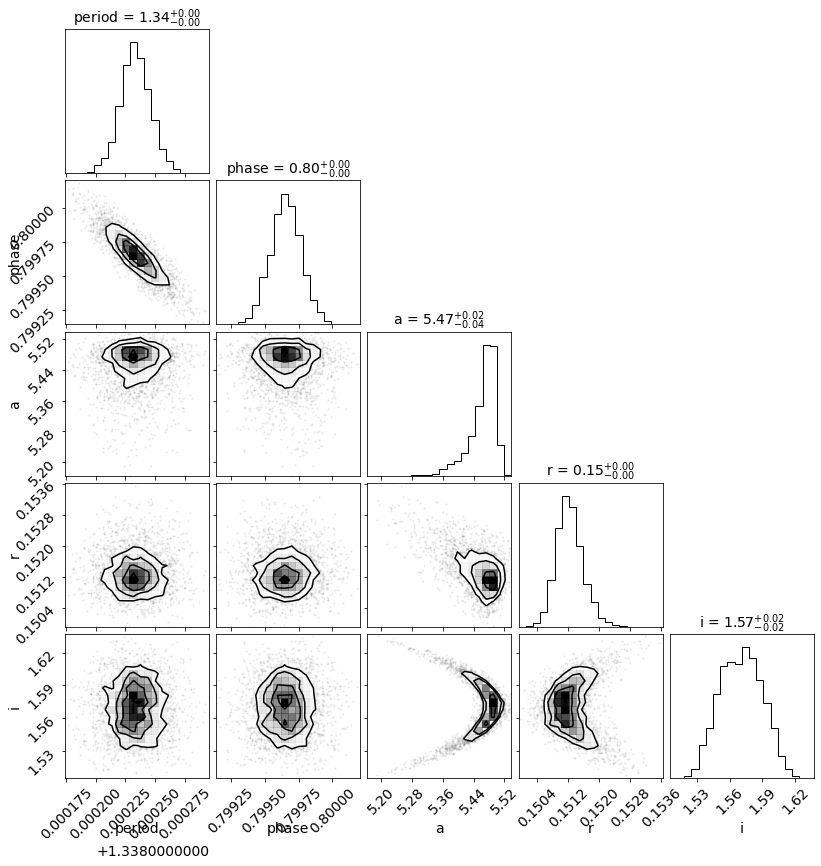

In [100]:
from ultranest.plot import cornerplot
cornerplot(result)

In [101]:
for i in range(5):
    qs = np.quantile(result['samples'][:,i], q=[0.16, 0.5, 0.84])
    print('%s\t %.6f +%.6f -%.6f'%(param_names[i], qs[1], qs[2] - qs[1],  qs[1] - qs[0]))

period	 1.338233 +0.000013 -0.000012
phase	 0.799654 +0.000112 -0.000111
a	 5.473367 +0.020137 -0.037242
r	 0.151213 +0.000355 -0.000300
i	 1.570701 +0.019946 -0.020415


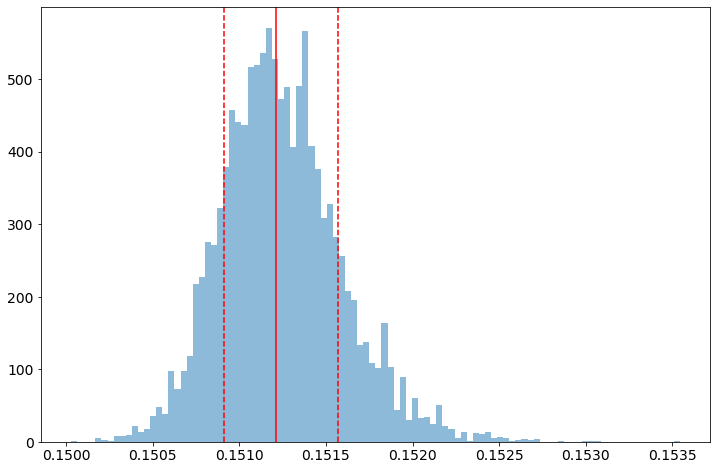

In [102]:
plt.hist(result['samples'][:,3], bins=100, alpha=0.5);
qs = np.quantile(result['samples'][:,3], q=[0.16, 0.5, 0.84])
plt.axvline(qs[0], c='r', ls='--')
plt.axvline(qs[1], c='r', ls='-')
plt.axvline(qs[2], c='r', ls='--')

## Credible Interval for r/R (Bayesian)

In [103]:
print('r/R = %.4f +%.5f -%.5f (68%% C.I.)'%(qs[1], qs[2] - qs[1], qs[1] - qs[0]))

r/R = 0.1512 +0.00035 -0.00030 (68% C.I.)


## Confidence Level Interval for r/R (Frequentist)

In [104]:
print('r/R = %.4f +%.5f -%.5f (68%% C.L.)'%(mle_transit.x[3], np.max(interval) - mle_transit.x[3], mle_transit.x[3] - np.min(interval)))

r/R = 0.1511 +0.00031 -0.00024 (68% C.L.)


##  Confidence Level Interval Paper

In [105]:
print('r/R = %.4f +%.5f -%.5f (68%% C.L.)'%(0.15201 ,0.00040, 0.00033))

r/R = 0.1520 +0.00040 -0.00033 (68% C.L.)


Text(0.5, 0, 'r/R')

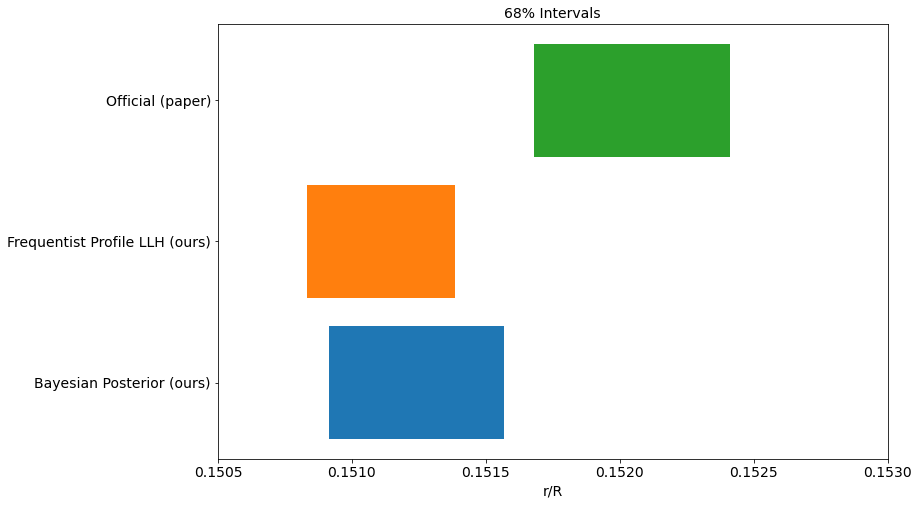

In [106]:
plt.barh(1, qs[2] - qs[0], left=qs[0])
plt.barh(2, max(interval) - min(interval), left=min(interval))
plt.barh(3, 0.00040 + 0.00033, left=0.15201- 0.00033)
plt.gca().set_xlim(0.1505, 0.153)
plt.gca().set_yticks([1,2,3])
plt.gca().set_yticklabels(['Bayesian Posterior (ours)','Frequentist Profile LLH (ours)', 'Official (paper)'])
plt.gca().set_title("68% Intervals")
plt.gca().set_xlabel('r/R')

## Model Selection

In [107]:
param_names_box = ['period', 'phase', 'length', 'r']

In [112]:
bounds_box = np.stack([mle_box.x, mle_box.x]).T
bounds_box[:,0] *= 0.9
bounds_box[:,1] *= 1.1

In [113]:
def likelihood_box(params):
    return -nllh_box(params, t, f)

In [114]:
def prior_transform_box(cube):
    params = cube * (bounds_box[:,1] - bounds_box[:,0]) + bounds_box[:,0]
    return params

In [115]:
sampler_box = ultranest.ReactiveNestedSampler(param_names_box, likelihood_box, prior_transform_box)

In [116]:
%%time
result_box = sampler_box.run()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=8e+04  1266.54 [81266.5407..81266.5407]*| it/evals=14960/338115 eff=4.4298% N=400 
[ultranest] Likelihood function evaluations: 338167
[ultranest]   logZ = 8.123e+04 +- 0.2278
[ultranest] Effective samples strategy satisfied (ESS = 2149.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.23, need <0.5)
[ultranest]   logZ error budget: single: 0.27 bs:0.23 tail:0.01 total:0.23 required:<0.50
[ultranest] done iterating.
CPU times: user 4min 41s, sys: 1.76 s, total: 4min 43s
Wall time: 4min 40s


In [142]:
logK = result['logz'] - result_box['logz']

In [143]:
logK

1347.52681724781